In [92]:
import astropy.coordinates as coord
import astropy.units as u
import astropy.table as at
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jaxopt
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline

import numpyro.distributions as dist

import gala.coordinates as gc
from pyia import GaiaData
from gaiaunlimited.selectionfunctions import DR3SelectionFunctionTCG
from stream_membership.gridgmm import CensoredGridGMM

In [71]:
selfun = DR3SelectionFunctionTCG(mode='multi')

### Load Gaia data for GD-1, with proper motion mask applied:

In [76]:
g = GaiaData('../data/tmp/gd1-gaiadr3-pm-mask.fits')

In [129]:
g_c = g.get_skycoord(distance=False)
data_S = selfun.query(g_c, g.phot_g_mean_mag.value)

Here, since we're not actually modeling the sky position, we'll use the average selection function at a few locations along the stream:

In [84]:
c = coord.SkyCoord(
    gc.GD1Koposov10(phi1=np.linspace(-100, 20, 32) * u.deg, phi2=np.zeros(32) * u.deg)
).icrs
G_grid = np.linspace(17, 21.5, 128)
S = selfun.query(c[None], G_grid[:, None])
S.shape

(128, 32)

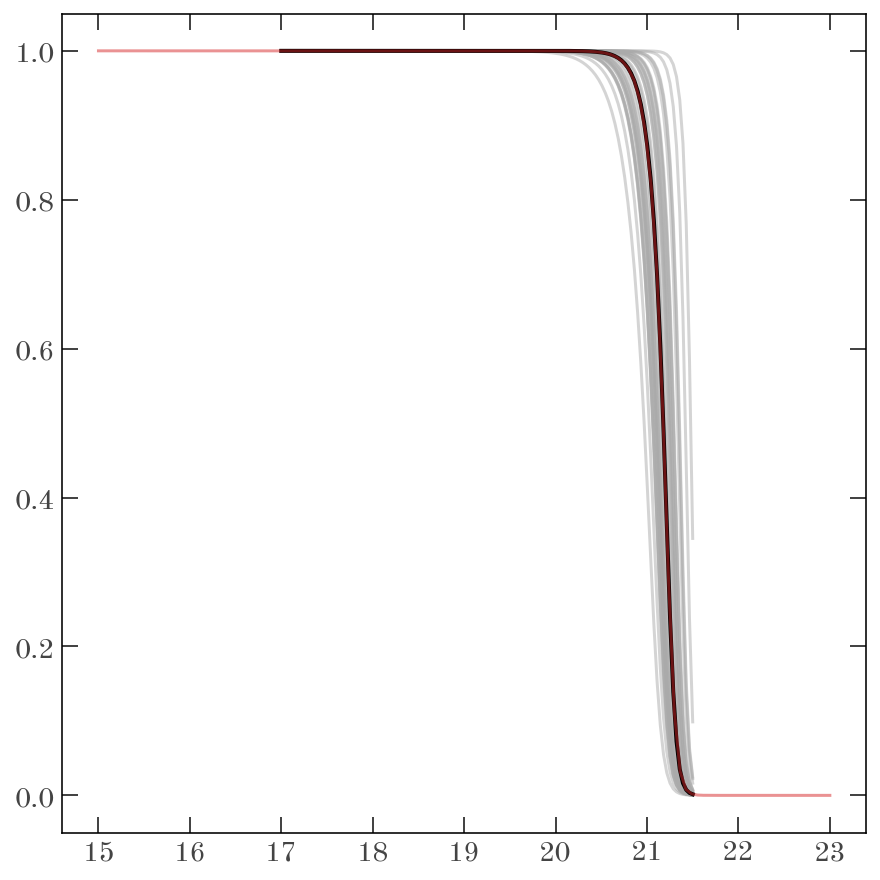

In [110]:
plt.plot(G_grid, S, color="#aaaaaa", alpha=0.5, marker="")
plt.plot(G_grid, np.median(S, axis=1), color="k", marker="", lw=2)

lnS_func = InterpolatedUnivariateSpline(G_grid, np.log(np.median(S, axis=1)), k=1)

big_G_grid = np.linspace(15, 23, 128)
plt.plot(
    big_G_grid, np.exp(lnS_func(big_G_grid)), color="tab:red", alpha=0.5, marker=""
)

But we need to convert S(G) to S(g-i, g):

In [127]:
from scipy.stats import binned_statistic_2d

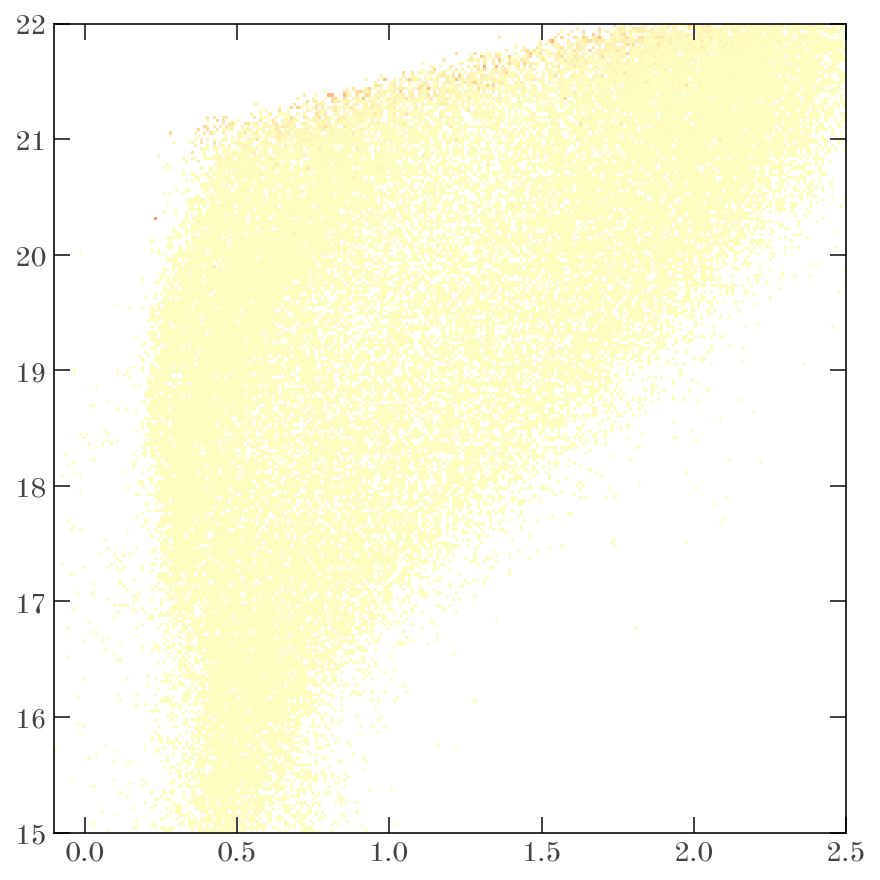

In [133]:
stat = binned_statistic_2d(g.g0-g.i0, g.g0, data_S, bins=(np.linspace(-0.1, 2.5, 256), np.linspace(15, 22, 256)))
plt.pcolormesh(
    stat.x_edge, stat.y_edge, stat.statistic.T, vmin=0, vmax=1
);

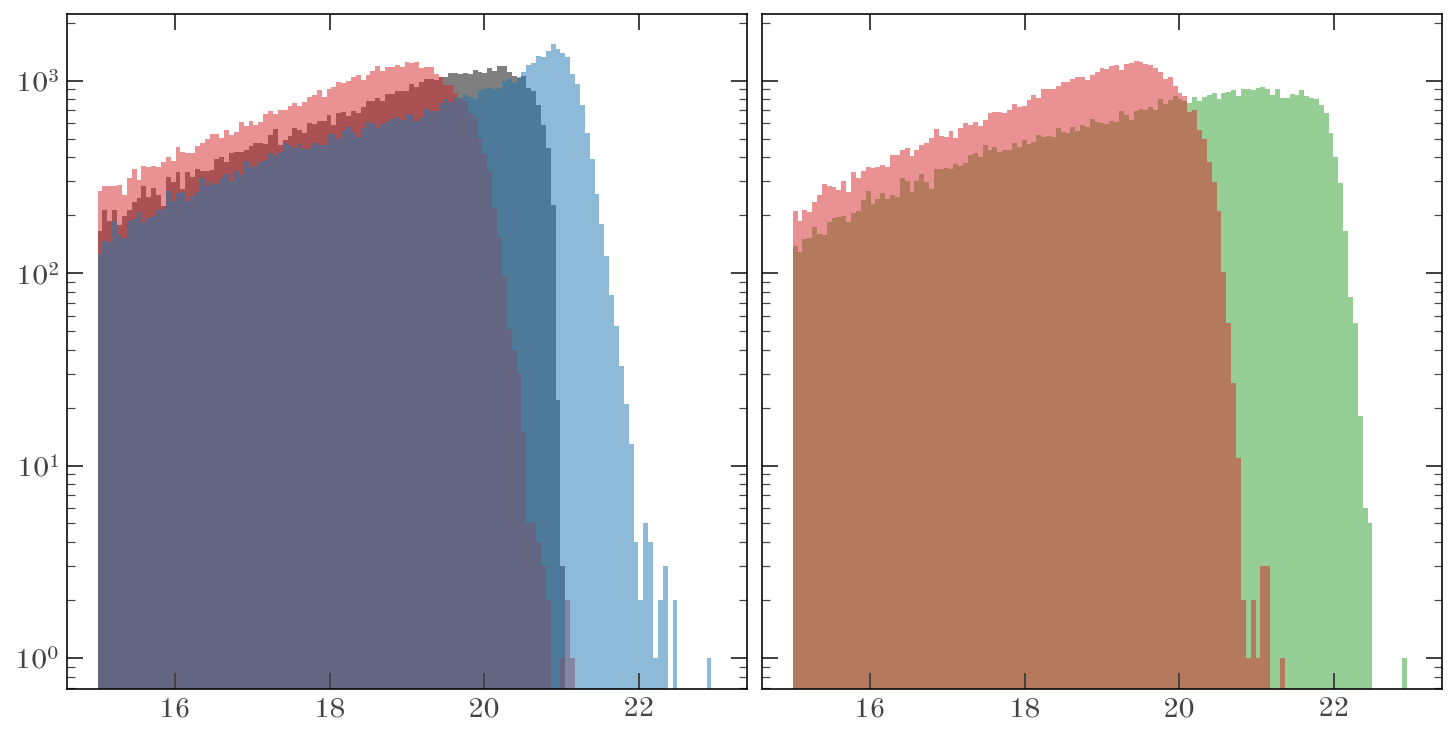

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
_bins = np.linspace(15, 23, 128)

ax = axes[0]
ax.hist(g['phot_g_mean_mag'], bins=_bins, alpha=0.5);
ax.hist(g['phot_rp_mean_mag'], bins=_bins, color='tab:red', alpha=0.5);
ax.hist(g['phot_bp_mean_mag'], bins=_bins, color='tab:blue', alpha=0.5);
ax.set_yscale('log')

ax = axes[1]
ax.hist(g['gMeanPSFMag'], bins=_bins, color='tab:green', alpha=0.5);
ax.hist(g['iMeanPSFMag'], bins=_bins, color='tab:red', alpha=0.5);

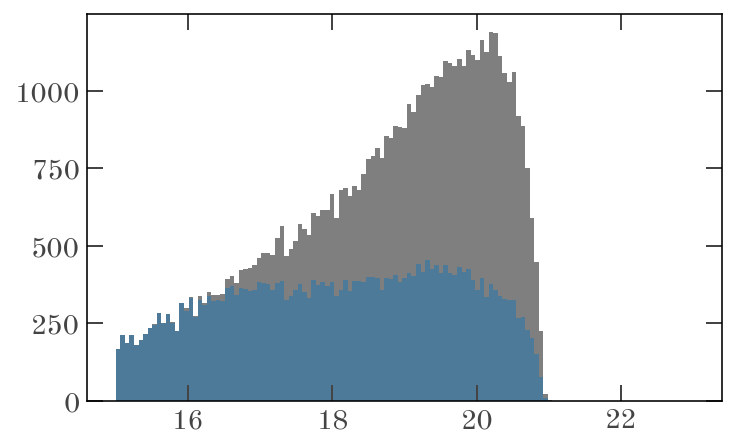

In [4]:
plt.figure(figsize=(5, 3))
plt.hist(g['phot_g_mean_mag'], bins=_bins, alpha=0.5);
plt.hist(g['phot_g_mean_mag'][(g['g0'] - g['i0']) < 1], bins=_bins, alpha=0.5);

I think it's ok to cut on g-i color because they are totally independent of G mag.

In [116]:
nodes = np.array(
    [
        [0.5, 21.5],
        [0.35, 21],
        [0.1, 20],
        [0.1, 17.5],
        [0.5, 17.5],
        [0.6, 19],
        [0.8, 20],
        [1, 21.5],
    ]
)
cmd_box_path = mpl.path.Path(nodes)

data = np.stack((g["g0"] - g["i0"], g["g0"])).T
cmd_box_mask = cmd_box_path.contains_points(data)
data = data[cmd_box_mask]
data_G = g["phot_g_mean_mag"][cmd_box_mask]

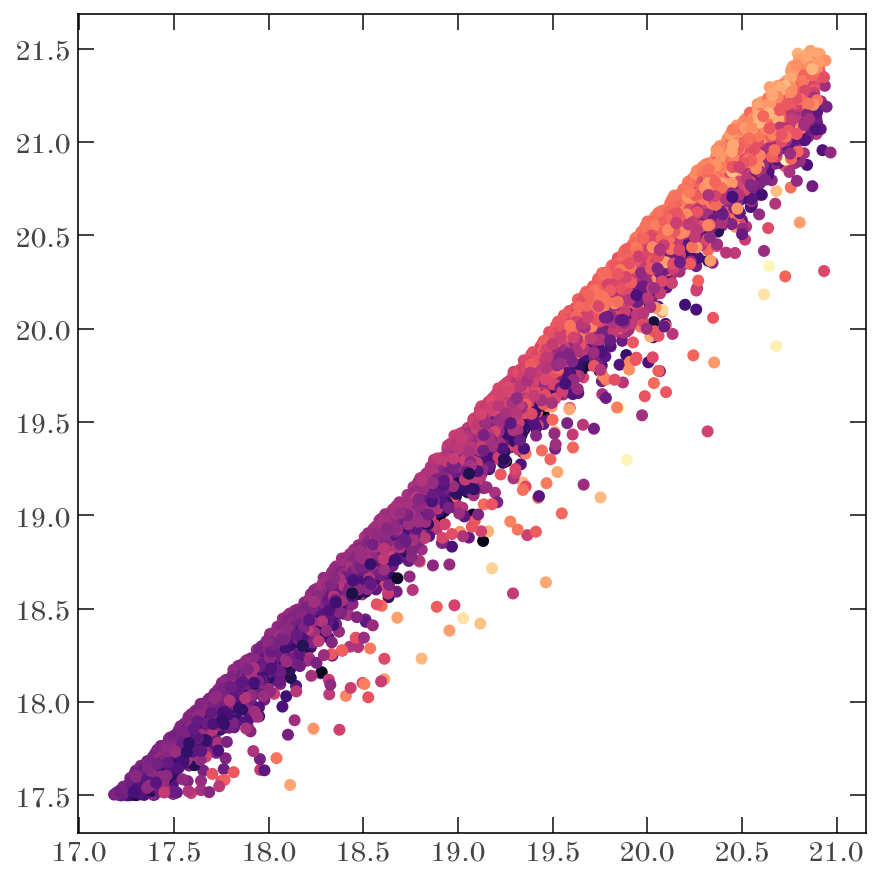

In [126]:
# plt.scatter(data_G, g["g0"][cmd_box_mask], c=data[:, 0])
plt.scatter(
    data_G, g["g0"][cmd_box_mask], c=(g.gMeanPSFMag - g.iMeanPSFMag)[cmd_box_mask]
)

(22.0, 15.0)

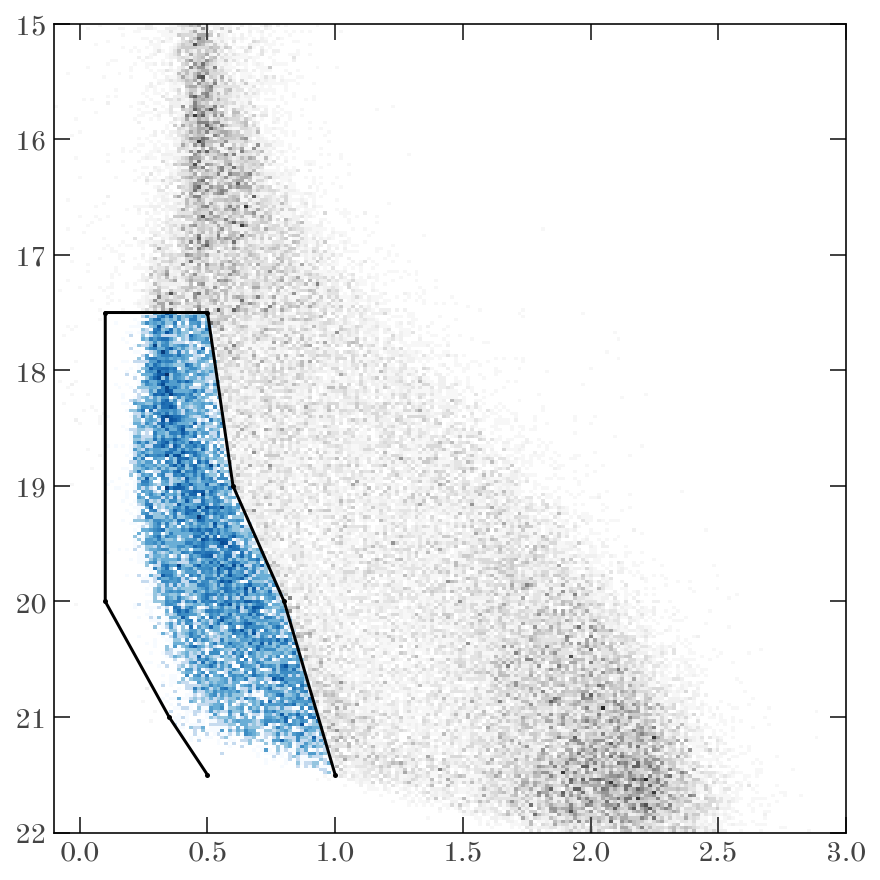

In [115]:
_bins = (np.linspace(-0.1, 3, 201), np.linspace(15, 22, 251))
plt.hist2d(g["g0"] - g["i0"], g["g0"], bins=_bins, cmap="Greys")
plt.hist2d(data[:, 0], data[:, 1], bins=_bins, cmap="Blues", norm=mpl.colors.LogNorm())
plt.plot(nodes[:, 0], nodes[:, 1])
plt.xlim(-0.1, 3)
plt.ylim(22, 15)

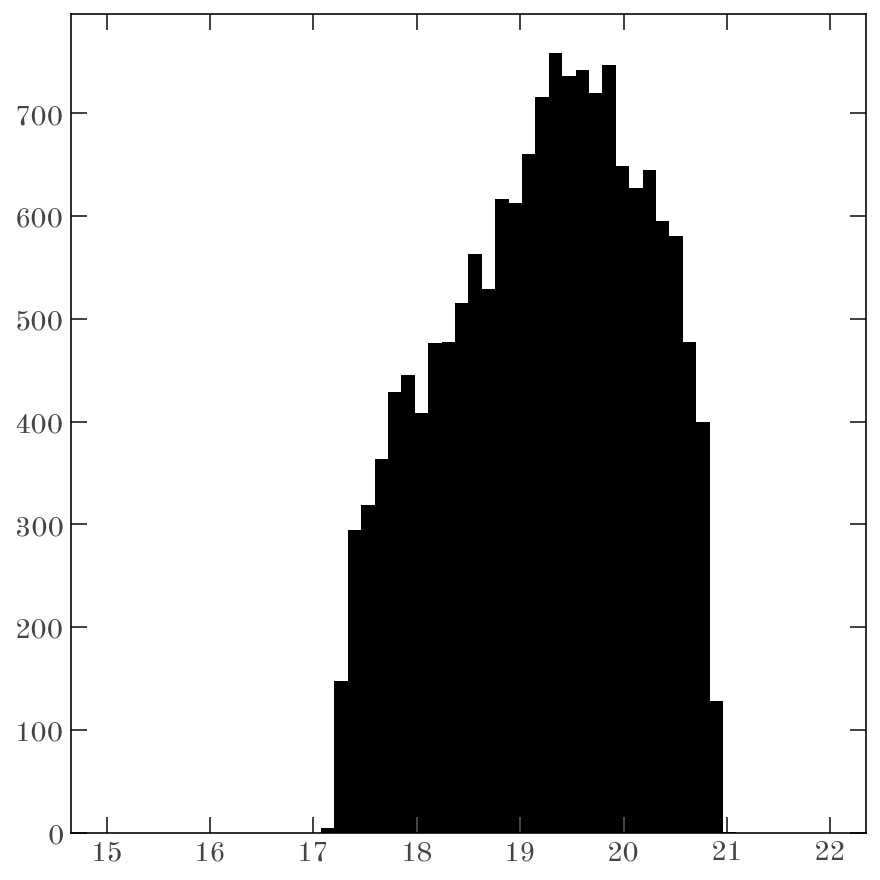

In [68]:
plt.hist(data_G, bins=np.linspace(15, 22, 55));

### Now try to fit the CMD with an isochrone + gaussian grid

In [10]:
dx = 0.04
dy = 0.18
locs = np.stack(np.meshgrid(np.arange(0, 1.2+1e-3, dx), np.arange(17, 22+1e-3, dy)))
locs = locs.reshape(2, -1).T
gmm = CensoredGridGMM(locs, bandwidth=[dx, dy], censor_path=cmd_box_path, ngrid=255)
gmm._component_mask.sum()

488

(22.5, 17.0)

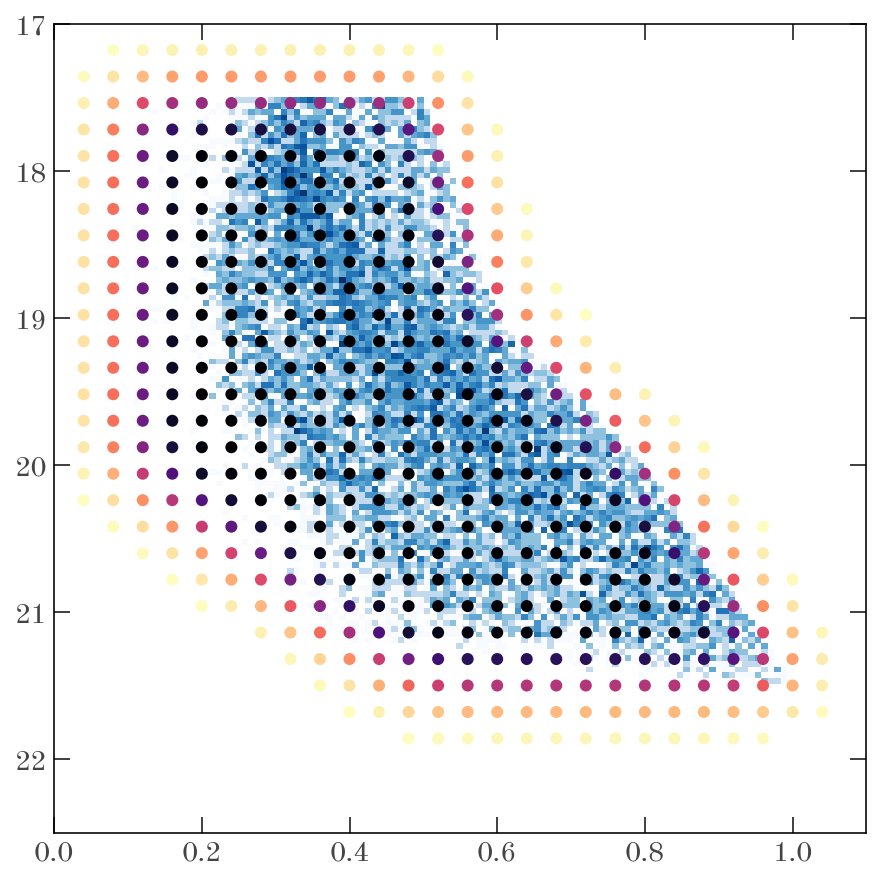

In [12]:
plt.hist2d(
    data[:, 0], data[:, 1], bins=(101, 101), cmap="Blues", norm=mpl.colors.LogNorm()
)
plt.scatter(
    gmm.locs[gmm._component_mask, 0],
    gmm.locs[gmm._component_mask, 1],
    c=np.exp(gmm._ln_prob_mass_fac),
    cmap='magma_r'
)
plt.xlim(0, 1.1)
plt.ylim(22.5, 17)

In [13]:
ncomps = gmm._component_mask.sum()

In [32]:
from functools import partial
@partial(jax.jit, static_argnums=0)
def objective_poisson(self, pars, data):
    N = data.shape[0]
    ll = jnp.sum(self.log_prob(pars, data)) + N * jnp.log(pars['N0']) - pars['N0']
    return -ll / N

In [34]:
init_pars = {"z": np.zeros(ncomps - 1), "N0": float(data.shape[0])}
opt = jaxopt.ScipyBoundedMinimize(
    method="L-BFGS-B", fun=lambda p, data: objective_poisson(gmm, p, data=data)
)
opt_res = opt.run(
    init_params=init_pars,
    data=data,
    bounds=({"z": np.full(ncomps - 1, -8), "N0": 0.}, {"z": np.full(ncomps - 1, 8), "N0": 1e8}),
)

In [35]:
bins1d = (np.linspace(0, 1.1, 128), np.linspace(17, 22.5, 128))
bins = np.meshgrid(*bins1d)

bins1dc = [0.5 * (b[:-1] + b[1:]) for b in bins1d]
binsc = np.meshgrid(*bins1dc)

eval_grid = (
    np.stack(binsc)
    .reshape(2, -1)
    .T
)
opt_ln_probs = gmm.log_prob(opt_res.params, eval_grid).reshape(binsc[0].shape)
eval_grid_mask = gmm.censor_path.contains_points(eval_grid).reshape(binsc[0].shape)

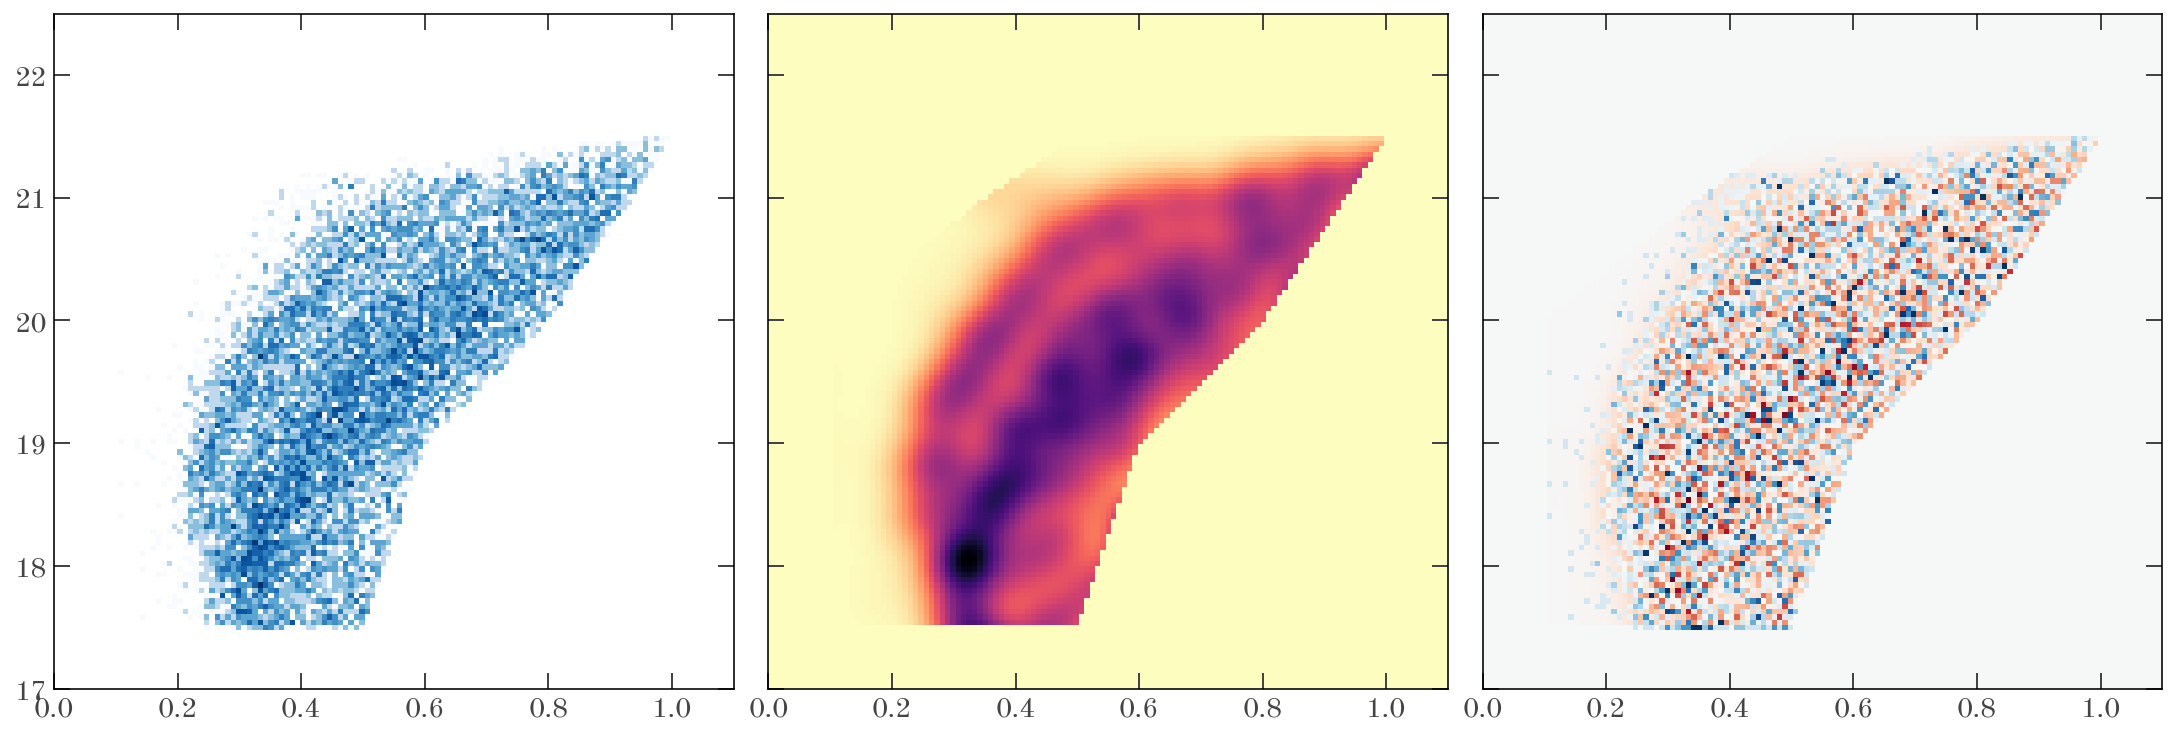

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

H, xe, ye = np.histogram2d(data[:, 0], data[:, 1], bins=bins1d)

axes[0].pcolormesh(
    xe,
    ye,
    H.T,
    norm=mpl.colors.LogNorm(),
    cmap="Blues",
)

tmp = np.exp(opt_ln_probs)
tmp[~eval_grid_mask] = 0.0
tmp *= opt_res.params['N0'] / tmp[eval_grid_mask].sum()
axes[1].pcolormesh(bins[0], bins[1], tmp, cmap="magma_r")

axes[2].pcolormesh(bins[0], bins[1], H.T - tmp, cmap='RdBu', vmin=-5, vmax=5)